In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.X_m = dict(bins=np.linspace(500,2000,30))
varinfo.Y1_m = dict(bins=np.linspace(0,1000,30))
varinfo.Y2_m = dict(bins=np.linspace(0,1000,30))
varinfo.H1Y1_m = dict(bins=np.linspace(0,250,30))
varinfo.H2Y1_m = dict(bins=np.linspace(0,250,30))
varinfo.H1Y2_m = dict(bins=np.linspace(0,250,30))
varinfo.H2Y2_m = dict(bins=np.linspace(0,250,30))

In [3]:
signal = ObjIter(Tree(fn) for fn in fc.eightb.preselection_ranked_quadh.signal_list[::3])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

In [4]:
bkg = qcd + ttbar

In [5]:
def _signal_(tree):
  tree.color=None
signal.apply(_signal_)

[None, None, None]

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


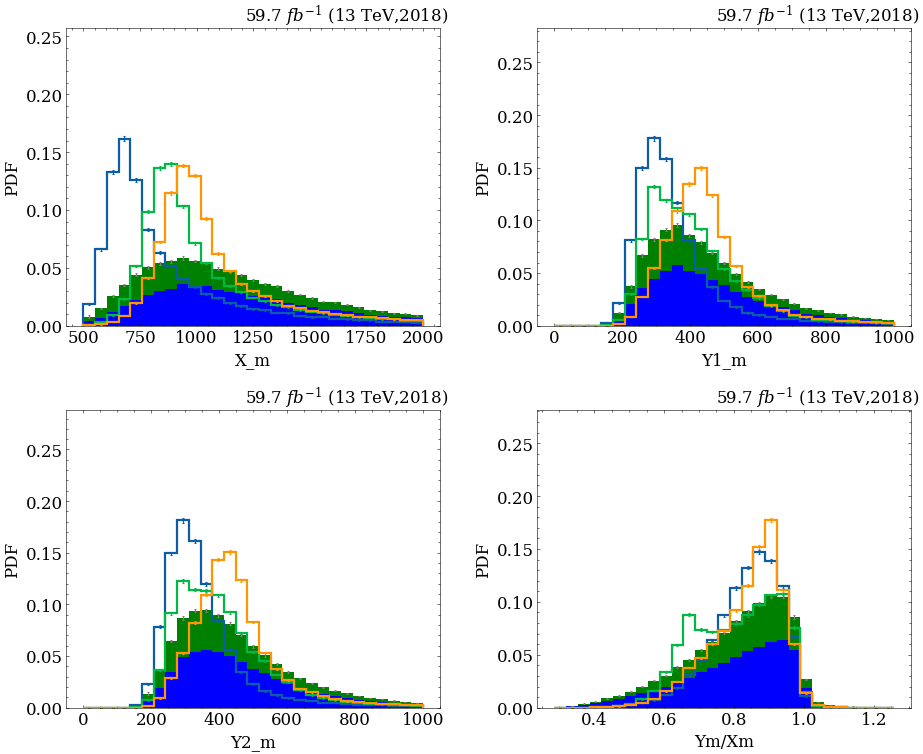

In [13]:
class xy(ObjTransform):
  def __call__(self, t):
    return np.sqrt(2*((t.Y1_m/t.X_m)**2 + (t.Y2_m/t.X_m)**2))

study.quick(
  signal+bkg, stacked=True,
  varlist=['X_m','Y1_m','Y2_m', xy(xlabel='Ym/Xm')],
  efficiency=True,
)

In [5]:
(signal+bkg).apply(lambda t:build_collection(t,'H\dY\d','higgs', ptordered=True))

[None, None, None, None, None]

In [20]:
def y_dm(t):
  hp4 = [ build_p4(remove_name(t[[ f'higgs_{var}' for var in ('pt','m','eta','phi') ]][:,:,i], 'higgs')) for i in range(4) ]

  def comb_ydm(comb):
    ym = [(hp4[y[0]]+hp4[y[1]]).m for y in comb]
    return ym[0], ym[1]
  ys = [  comb_ydm(comb) for comb in combinations(4, [2, 2])  ]

  y_asyms = [ (y[0]-y[1])/(y[0]+y[1]) for y in ys ]
  y_ratios = [ (y[0]-y[1])/t.X_m for y in ys ]
  y_sums = [ (y[0]+y[1])/t.X_m for y in ys ]

  t.extend(
    y_asyms=ak_stack(y_asyms),
    y_ratios=ak_stack(y_ratios),
    y_sums=ak_stack(y_sums)
  )


In [21]:
(signal+bkg).apply(y_dm)


[None, None, None, None, None]

100%|██████████| 9/9 [00:16<00:00,  1.84s/it]


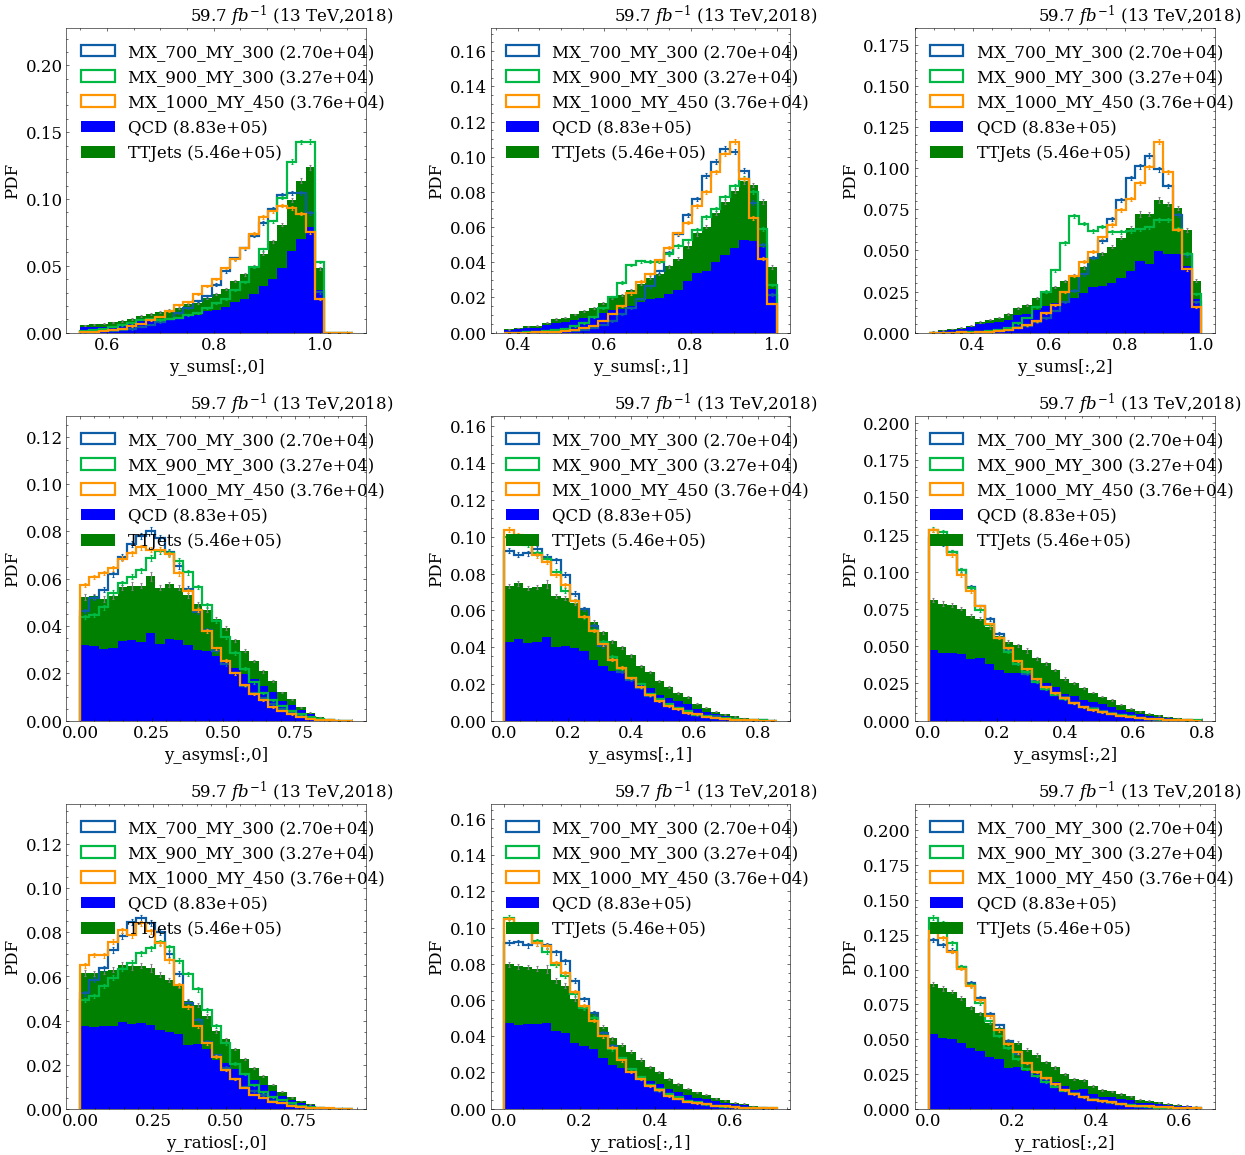

In [25]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  transforms=np.abs,
  varlist=[ f'y_{var}[:,{i}]' for var in ('sums','asyms','ratios') for i in range(3)],
  dim=(-1,3),
  efficiency=True,
)

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


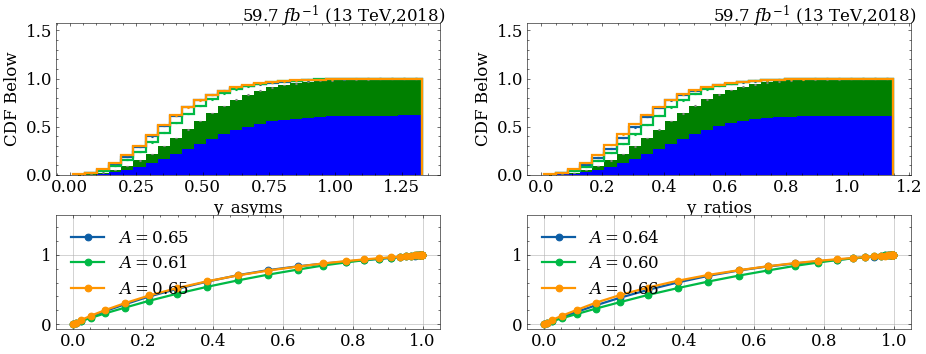

In [32]:
study.quick(
  signal+bkg, stacked=True,
  transforms=lambda v : np.sqrt(ak.sum(v**2,axis=-1)),
  varlist=['y_asyms','y_ratios'],

  # efficiency=True,

  cumulative=1,
  correlation=True
)

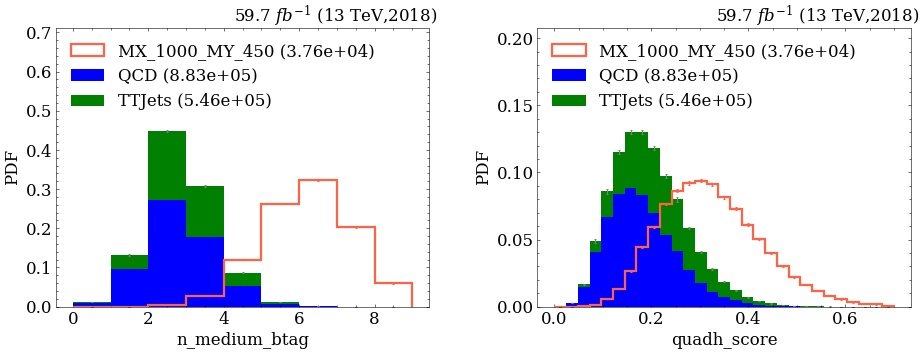

In [ ]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_medium_btag','quadh_score'],
  binlist=[None, (0,0.7,30)],
  efficiency=True,
  saveas='selection_variables'
)

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


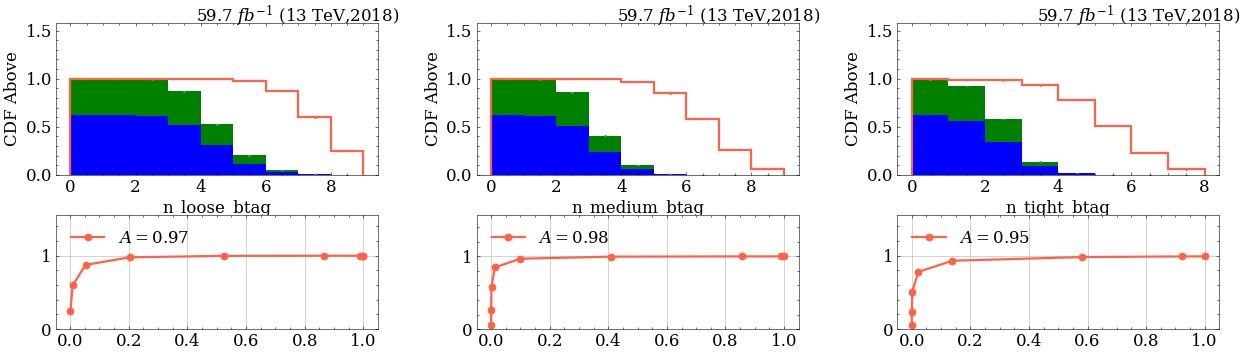

In [ ]:

study.quick(
  signal+bkg, stacked=True,
  varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
  dim=(-1,3),
  efficiency=True,
  cumulative=-1,
  correlation=True,
)

In [ ]:
bins = np.arange(10)

np.linspace( bins[0], bins[-1], len(bins)-1 )

array([0.   , 1.125, 2.25 , 3.375, 4.5  , 5.625, 6.75 , 7.875, 9.   ])

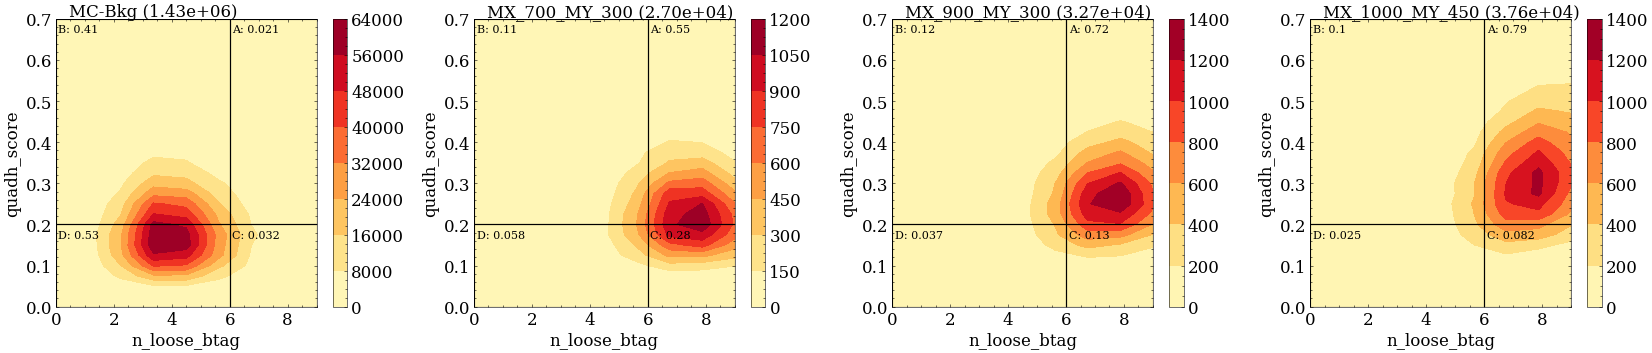

In [ ]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(4, dim=(-1,4))

v1 = 'n_loose_btag'
v2 = 'quadh_score'

region = dict(x_r=(0,6,9), y_r=(0,0.2,0.7))

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  contour=True,
  figax=(fig,axs[0]),
  exe=draw_abcd(**region)
)

study.quick2d(
  signal,
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  figax=(fig,axs[1:]),
  dim=(-1,3),
  contour=True,
  exe=draw_abcd(**region)
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

In [ ]:
abcd_regions = {
  'nominal':                    [(0,5,9),(0,0.2 ,0.7)],
  'validation/btag_hi':         [(3,5,9),(0,0.2 ,0.7)],
  'validation/btag_lo':         [(0,3,5),(0,0.2 ,0.7)],
  'validation/score_lo':        [(0,5,9),(0,0.15,0.2)],
  'validation/btag_hi_score_lo':[(3,5,9),(0,0.15,0.2)],
  'validation/btag_lo_score_lo':[(0,3,5),(0,0.15,0.2)]
}

In [ ]:
abcd_regions = {
  'nominal':                    [(0,6,9),(0,0.2 ,0.7)],
  # 'validation/btag_hi':         [(3,5,9),(0,0.2 ,0.7)],
  # 'validation/btag_lo':         [(0,3,5),(0,0.2 ,0.7)],
  # 'validation/score_lo':        [(0,5,9),(0,0.15,0.2)],
  # 'validation/btag_hi_score_lo':[(3,5,9),(0,0.15,0.2)],
  # 'validation/btag_lo_score_lo':[(0,3,5),(0,0.15,0.2)]
}

In [ ]:
region = 'nominal'
v1_r, v2_r = abcd_regions[region]
r_a, r_b, r_c, r_d = get_abcd_masks(v1_r, v2_r)
(k_target, e_target), (k_factor, e_factor), (n_model, e_model) = get_abcd_scale(r_a, r_b, r_c, r_d)

(k_factor, 100*e_factor/k_factor)

0.02126459831119332 0.41398747642201117 0.03156280310318263 0.5331821678329811


(0.059197034348436144, 2.8258090310073274)

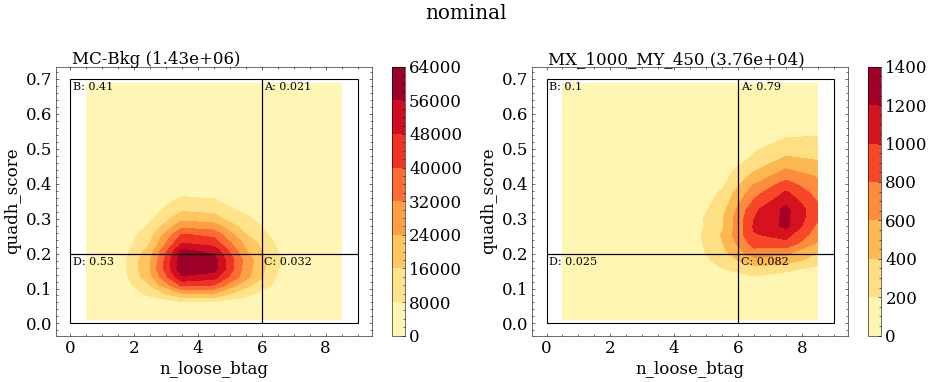

In [ ]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(2)

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  contour=True,
  figax=(fig,axs[0]),
  exe=draw_abcd(x_r=v1_r, y_r=v2_r)
)

study.quick2d(
  signal,
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  figax=(fig,axs[1]),
  contour=True,
  exe=draw_abcd(x_r=v1_r, y_r=v2_r),
  title=region,
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

In [ ]:
(n_model, e_model/n_model)

(0.09162395354977322, 0.015419397102709311)

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


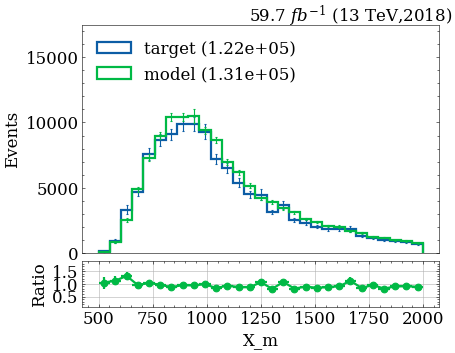

In [ ]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',

  ratio=True,

  saveas='model_X_m'
)

In [ ]:
ratio = k_target/k_factor
# error = ratio*np.sqrt( (e_target/k_target)**2 + (e_factor/k_factor)**2 )
error = ratio*np.sqrt( (e_factor/k_factor)**2 )

ratio, error/ratio

(1.1350352663777197, 0.04978759899905877)

In [ ]:
x = np.linspace(0, 1.5, 1000)
y = f_stats.kstwobign.sf(x)

In [ ]:
from scipy import optimize

def f(x):
  return np.abs(f_stats.kstwobign.sf(x) - 0.05)

optimize.fmin(f, 1)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 14
         Function evaluations: 28


array([1.35810547])

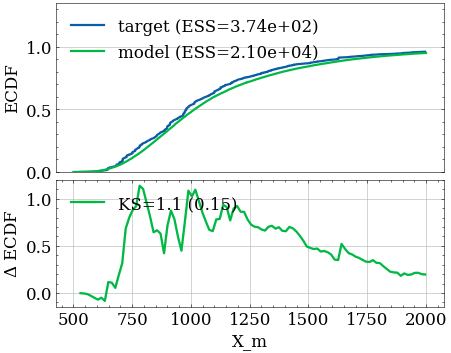

In [ ]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'ESS={np.sum(h.weights)**2/np.sum(h.weights**2):0.2e}',

  histo=False,
  empirical=True,
  e_legend=True,
  e_ylim=(0,1.35),

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_kstest'
)

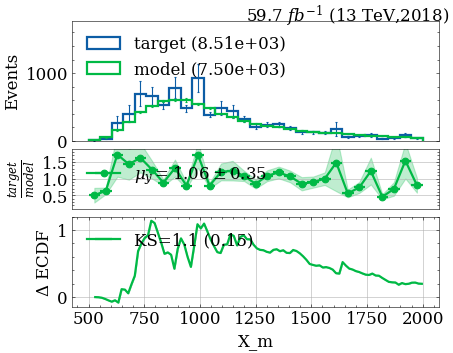

In [ ]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',
  legend_loc='upper left',

  ratio=True,
  r_size='50%',
  r_fill_error=True,
  r_ylabel=r'$\frac{target}{model}$',
  r_label_stat='y_mean_std',
  r_legend=True,
  r_legend_loc='upper left',

  empirical=True,
  # e_ylim=(-0.15,1.15),
  e_show=False,

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_full'
)